### [OpenCV SIFT tutorial](https://docs.opencv.org/master/da/df5/tutorial_py_sift_intro.html)

### [OpenCV feature extraction methods](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_table_of_contents_feature2d/py_table_of_contents_feature2d.html) -- corner detectors, SIFT, SURF, FAST, BRIEF, and ORB

### [Implementing SFIT from scratch in Python](https://lerner98.medium.com/implementing-sift-in-python-36c619df7945#:~:text=SIFT%2C%20which%20stands%20for%20Scale,translation%2C%20rotation%2C%20and%20illumination)

### [feature extraction general(kaggle)](https://www.kaggle.com/lorinc/feature-extraction-from-images)

### [feature extraction general(classic + ML)](https://towardsdatascience.com/image-feature-extraction-traditional-and-deep-learning-techniques-ccc059195d04)

In [18]:
import matplotlib.pyplot as plt 

import ipywidgets as widgets
import numpy as np
import os

import colour
from colour_hdri.plotting import plot_tonemapping_operator_image
colour.plotting.colour_style()
colour.utilities.describe_environment();

import sys, math
from glob import glob

import cv2 as cv
import skimage
import imageio

from astropy.io import fits
from colour.models import RGB_COLOURSPACES, RGB_luminance
from astrobf.utils.gmm import *

colorspace = RGB_COLOURSPACES['sRGB']

import astrobf
from astrobf.utils.gmm import gmm_mask

*                                                                             *
*   Interpreter :                                                             *
*       python : 3.7.9 (default, Aug 31 2020, 12:42:55)                       *
*                [GCC 7.3.0]                                                  *
*                                                                             *
*   colour-science.org :                                                      *
*       colour : 0.3.16                                                       *
*       colour-hdri : 0.1.8                                                   *
*                                                                             *
*   Runtime :                                                                 *
*       imageio : 2.9.0                                                       *
*       matplotlib : 3.3.2                                                    *
*       networkx : 2.5                  

# 1. Start here, Load data

In [2]:
wdir = '../../bf_data/EFIGI_catalog/fits_temp_Dec_28/'

#wdir = '../../OBSdata/efigi-1.6/ima_r/'
fns_g = glob(wdir+"*/*g.fits")
fns_r = glob(wdir+"*/*r.fits")
fns_i = glob(wdir+"*/*i.fits")

fns_g.sort()
fns_r.sort()
fns_i.sort()

# 2. Build a mask (GMM)

In [4]:
def chunks(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

import pickle

In [47]:
eps = 1e-10

sub_rows = 2
for ichunk, sub in enumerate(chunks(fns_r[:4], sub_rows**2)):
    fig, axs = plt.subplots(sub_rows, sub_rows)
    fig.set_size_inches(12,12)
    axs = axs.ravel()
    for ax, fn in zip(axs, sub):
        try:
            img_name = fn.split("/")[-2]
            hdulist = fits.open(fn)
            
            # Ensure pixel values are positive
            hdulist[0].data -= (hdulist[0].data.min() - eps)
            mask, img, mask_new = gmm_mask(hdulist,max_n_comp=20, sig_factor=2.0, verbose=False, do_plot=False)
            ax.imshow(np.log10(img))
            ax.imshow(mask, alpha=0.5)
            #mask_new = mask_hull(mask, ax)
            ax.text(0.05,0.05, img_name, transform=ax.transAxes)
            pickle.dump(mask_new, open(f"{img_name}_mask.pickle", "wb"))
        except:
            continue
    plt.tight_layout()
    plt.savefig(f"{ichunk}.png", dpi=144)
    plt.close()
    print(f'{ichunk}-th chunk done')

/home/hoseung/anaconda3/envs/tonemap/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/home/hoseung/anaconda3/envs/tonemap/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/home/hoseung/anaconda3/envs/tonemap/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/home/hoseung/anaconda3/envs/tonemap/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


0-th chunk done


In [148]:
# Load data for testing
import pickle


hdulist = fits.open(fns_r[174])
img = hdulist[0].data

mask_new = pickle.load(open("./PGC0007118_mask.pickle", 'rb'))

In [149]:
img[~mask_new] = 0
stamp = astrobf.utils.mask.gen_stamp(img, pad=10, aspect_ratio="no", eps=eps)
stamp += eps

# 3. Tone map (widget)

In [150]:
import ipywidgets as widgets
from ipywidgets import FloatSlider
from IPython.display import display

from astrobf.utils import tmo_utils 

def tonemapping_operator_generic_interactive(image,
                                             a=0.125,
                                             d=0.975,
                                             mid_in=0.25,
                                             mid_out=0.18):
    args = (a,d,mid_in, mid_out)
    return tmo_utils.plot_tonemapping_operator_image(
        tmo_utils.tonemapping_operator_generic(image, *args),
        np.squeeze(tmo_utils.tonemapping_operator_generic(np.linspace(0, 1, 512), *args)),
        title='Generic Tonemapping Operator')
    

tmo_widget = widgets.interactive(
            tonemapping_operator_generic_interactive,
            image=widgets.fixed(stamp),
            a=FloatSlider(min=0.1, max=1.5, step=0.01, continuous_update=False),
            d=FloatSlider(min=0.5, max=3.0, step=0.01, continuous_update=False),
            mid_in=FloatSlider(min=0.1, max=1, step=0.01, continuous_update=False),
            mid_out=FloatSlider(min=0.1, max=1, step=0.01, continuous_update=False))

In [151]:
display(tmo_widget)

interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='a', max=1.5, min=0.1, step=…

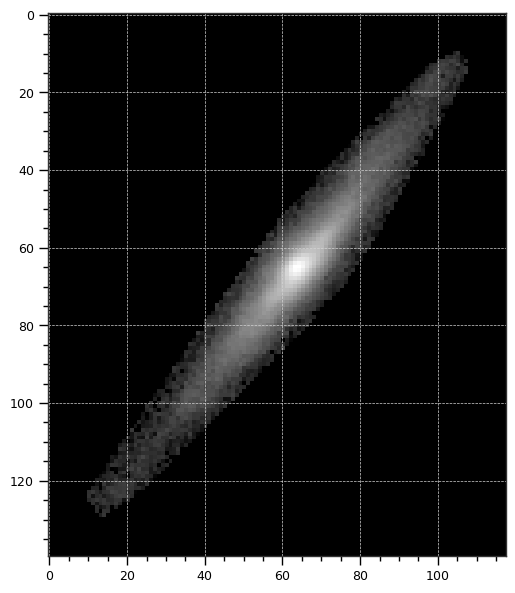

In [134]:
# Get the data out.
mapped = tmo_widget.result

plt.imshow(mapped)
plt.show()

# 4. Feature extraction (SIFT)

Note that SIFT and SURF are **patented**, and they are missing from OpenCV install by default.  
You need additional component to be installed into opencv_contrib package. 

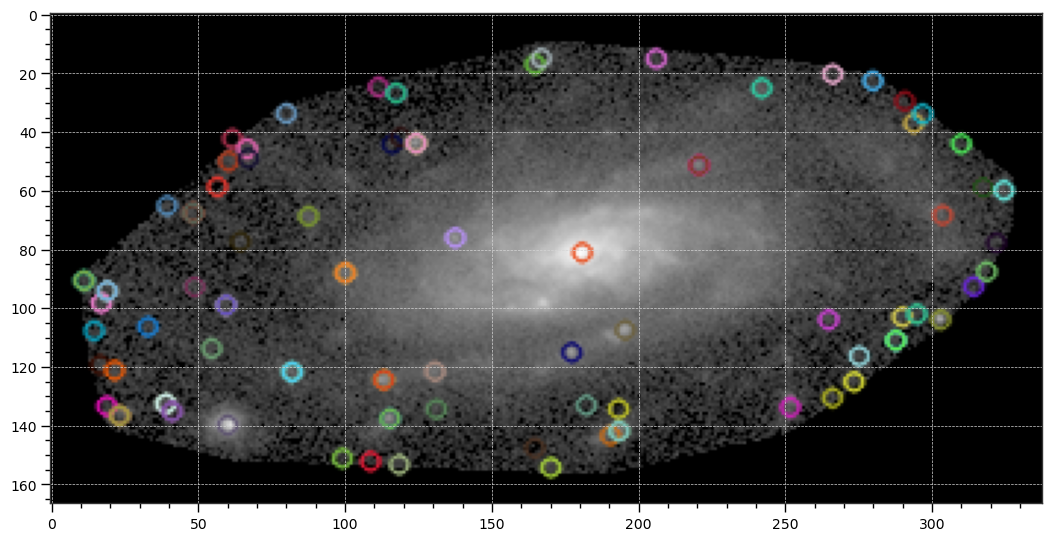

In [117]:
sift = cv.xfeatures2d.SIFT_create()
gray = (mapped*255).astype(np.uint8)
kp = sift.detect(gray,None)

shifted_img=cv.drawKeypoints(gray,kp,gray)

plt.imshow(shifted_img)
#cv.imwrite('sift_keypoints.jpg',shifted)

## What do they mean? How do I know I got reasonable feature set?

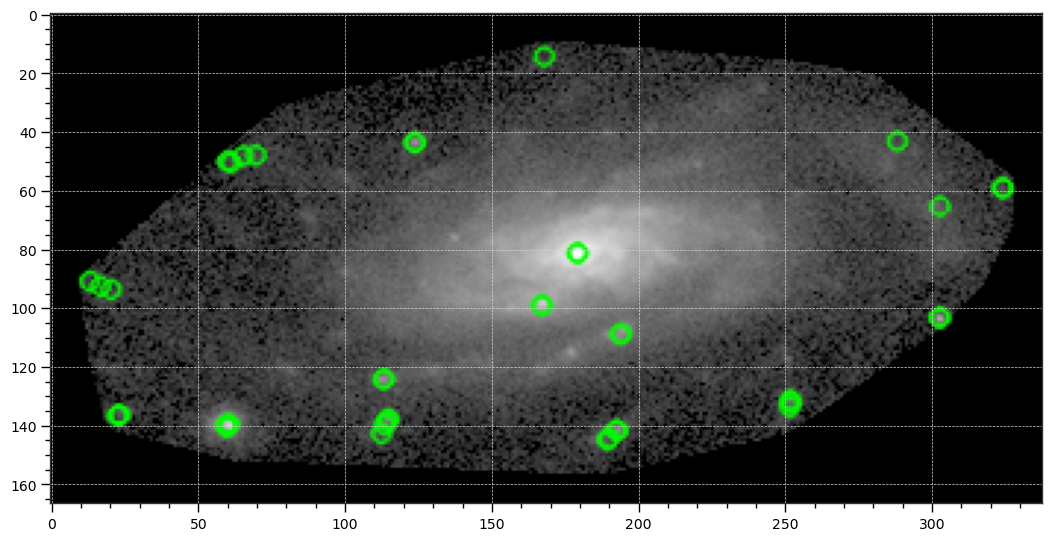

(<matplotlib.image.AxesImage at 0x7f51a7329b10>, None)

In [121]:
alg = cv.KAZE_create()
kp = alg.detect(gray)
kp, des = alg.compute(gray, kp)
img2 = cv.drawKeypoints(gray, kp, None, color=(0,255,0), flags=0)
plt.imshow(img2), plt.show()

# low-level feature 1. Color
## color correlogram

# low-level feature 2. texture
## Texture classification - Local Binary Pattern

## To do: ignore outside the galaxy mask 

In [126]:
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb

METHOD = 'uniform'

# settings for LBP
radius = 3
n_points = 8 * radius


def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')


def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')

def do_lbp(image):
    lbp = local_binary_pattern(image, n_points, radius, METHOD)

    # plot histograms of LBP of textures
    fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
    plt.gray()

    titles = ('edge', 'flat', 'corner')
    w = width = radius - 1
    edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
    flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
    i_14 = n_points // 4            # 1/4th of the histogram
    i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
    corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                     list(range(i_34 - w, i_34 + w + 1)))

    label_sets = (edge_labels, flat_labels, corner_labels)

    for ax, labels in zip(ax_img, label_sets):
        ax.imshow(overlay_labels(image, lbp, labels))

    for ax, labels, name in zip(ax_hist, label_sets, titles):
        counts, _, bars = hist(ax, lbp)
        highlight_bars(bars, labels)
        ax.set_ylim(top=np.max(counts[:-1]))
        ax.set_xlim(right=n_points + 2)
        ax.set_title(name)

    ax_hist[0].set_ylabel('Percentage')
    for ax in ax_img:
        ax.axis('off')


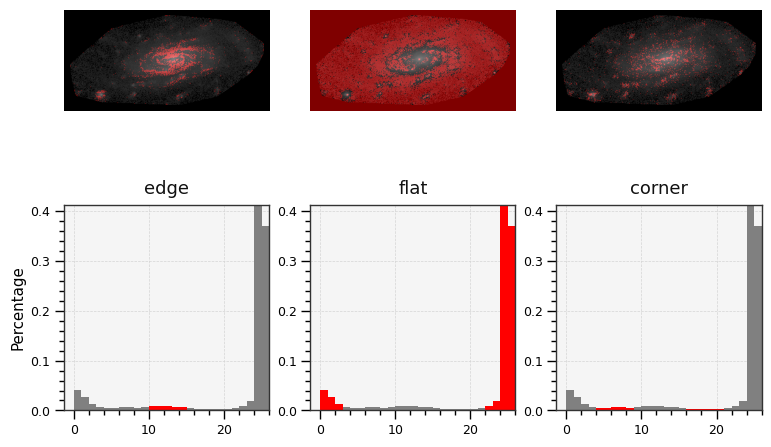

In [139]:
do_lbp(gray)

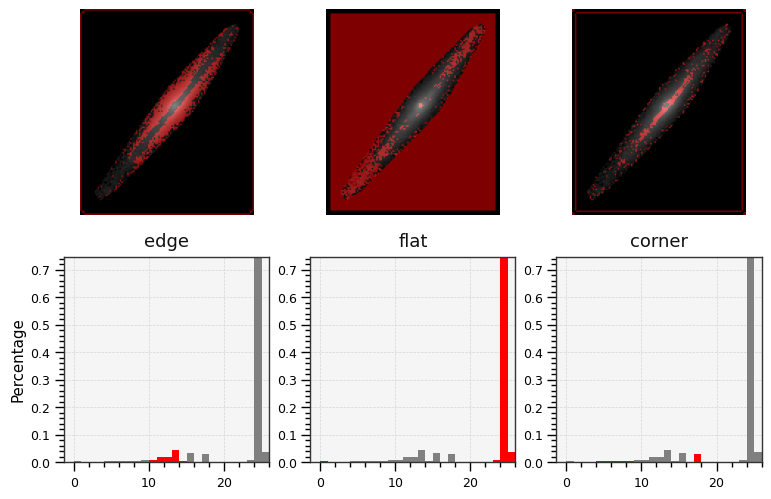

In [138]:
do_lbp(mapped)

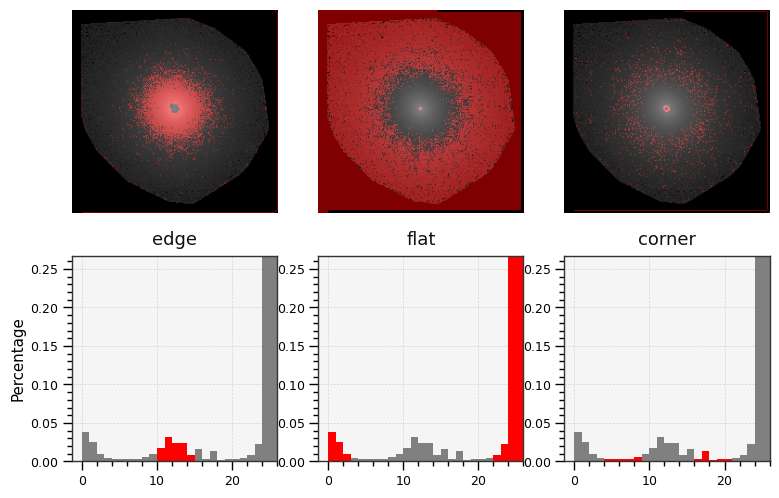

In [152]:
etg = tmo_widget.result
do_lbp(etg)

## Distance (divergence)

Rotated images matched against references using LBP:
original: spiral, rotated: 30deg, match result:  spiral
original: edgeon, rotated: 70deg, match result:  etg
original: etg, rotated: 145deg, match result:  etg


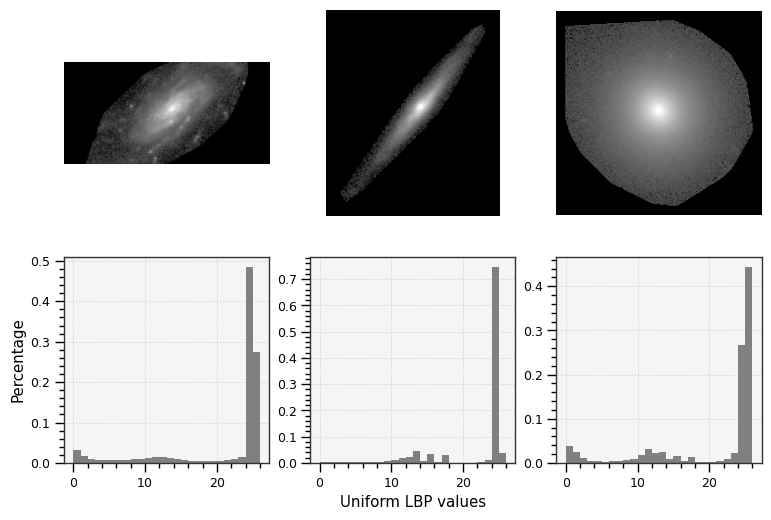

In [157]:
def kullback_leibler_divergence(p, q):
    p = np.asarray(p)
    q = np.asarray(q)
    filt = np.logical_and(p != 0, q != 0)
    return np.sum(p[filt] * np.log2(p[filt] / q[filt]))


def match(refs, img):
    best_score = 10
    best_name = None
    lbp = local_binary_pattern(img, n_points, radius, METHOD)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
    for name, ref in refs.items():
        ref_hist, _ = np.histogram(ref, density=True, bins=n_bins,
                                   range=(0, n_bins))
        score = kullback_leibler_divergence(hist, ref_hist)
        if score < best_score:
            best_score = score
            best_name = name
    return best_name


spiral = gray
edgeon = mapped
refs = {
    'spiral': local_binary_pattern(spiral, n_points, radius, METHOD),
    'edgeon': local_binary_pattern(edgeon, n_points, radius, METHOD),
    'etg': local_binary_pattern(etg, n_points, radius, METHOD)
}

# classify rotated textures
print('Rotated images matched against references using LBP:')
print('original: spiral, rotated: 30deg, match result: ',
      match(refs, rotate(spiral, angle=30, resize=False)))
print('original: edgeon, rotated: 70deg, match result: ',
      match(refs, rotate(edgeon, angle=70, resize=False)))
print('original: etg, rotated: 145deg, match result: ',
      match(refs, rotate(etg, angle=145, resize=False)))

# plot histograms of LBP of textures
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3,
                                                       figsize=(9, 6))
plt.gray()

ax1.imshow(rotate(spiral, angle=30, resize=False))
ax1.axis('off')
hist(ax4, local_binary_pattern(rotate(spiral, angle=30, resize=False), n_points, radius, METHOD))
ax4.set_ylabel('Percentage')

ax2.imshow(edgeon)
ax2.axis('off')
hist(ax5, refs['edgeon'])
ax5.set_xlabel('Uniform LBP values')

ax3.imshow(etg)
ax3.axis('off')
hist(ax6, refs['etg'])

plt.show()

## GLCM Texture Features
(DOI:10.1109/TSMC.1973.4309314)